# Predicting Bike Rentals

bIn this DataQuest project we will work with the data compiled by Hadi Fanaee-T at the University of Porto. It is available for downloading from [the University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

Here are the descriptions for the relevant columns:


|column|description|
|---|---|
|instant | A unique sequential ID number for each row|
|dteday | The date of the rentals|
|season | The season in which the rentals occurred|
|yr | The year the rentals occurred|
|mnth | The month the rentals occurred|
|hr | The hour the rentals occurred|
|holiday | Whether or not the day was a holiday|
|weekday | The day of the week (as a number, 0 to 7)|
|workingday | Whether or not the day was a working day|
|weathersit | The weather (as a categorical variable)|
|temp | The temperature, on a 0-1 scale|
|atemp | The adjusted temperature|
|hum | The humidity, on a 0-1 scale|
|windspeed | The wind speed, on a 0-1 scale|
|casual | The number of casual riders (people who hadn't previously signed up with the bike sharing program)|
|registered | The number of registered riders (people who had already signed up)|
|cnt | The total number of bike rentals (casual + registered)|


In this project, we'll try to predict the total number of bikes people rented in a given hour. We'll predict the `cnt` column using all of the other columns, except for `casual` and `registered`. To accomplish this, we'll create a few different machine learning models and evaluate their performance.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


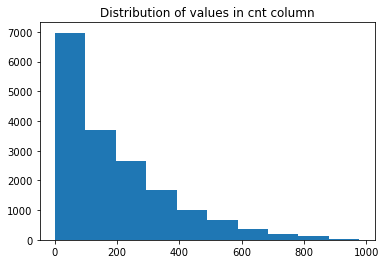

In [4]:
plt.hist(bike_rentals['cnt'])
plt.title('Distribution of values in cnt column')
plt.show()

In [21]:
bike_rentals['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

The distribution of values in our target column in continuous, so we are predicting real values, not labels. This means we will need to use a regression algorithm, and not classification. The best recommended metric to measure the preformance of regressors are MSE or RMSE. We will use RMSE as it is easier to interpret.

## Feature Engineering

The `hr` column now shows time in 0-24 format. We will convert it into categories from morning(1), afternoon(2), evening(3) and night-time(4) to better represent the time perceived by humans (who rent bikes) and use the new column instead.

In [6]:
def assign_label(value):
    if value >= 6 and value < 12:
        return 1
    elif value >= 12 and value < 18:
        return 2
    elif value >= 18 and value < 24:
        return 3
    elif value >= 0 and value < 6:
        return 4

bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

Let us now choose other features that we will use to predict the amount of bike rentals in `cnt` column. First, we will exclude `casual` and `registered` columns, because `cnt` is their sum. Besides, we will remove `dtday` column because we will not account for exact date in our predictions, and `temp` column and leave only `atemp`. 

In [39]:
bike_rentals_clean = bike_rentals.drop(['casual', 'registered', 'dteday', 'hr', 'temp'], axis=1)

<AxesSubplot:>

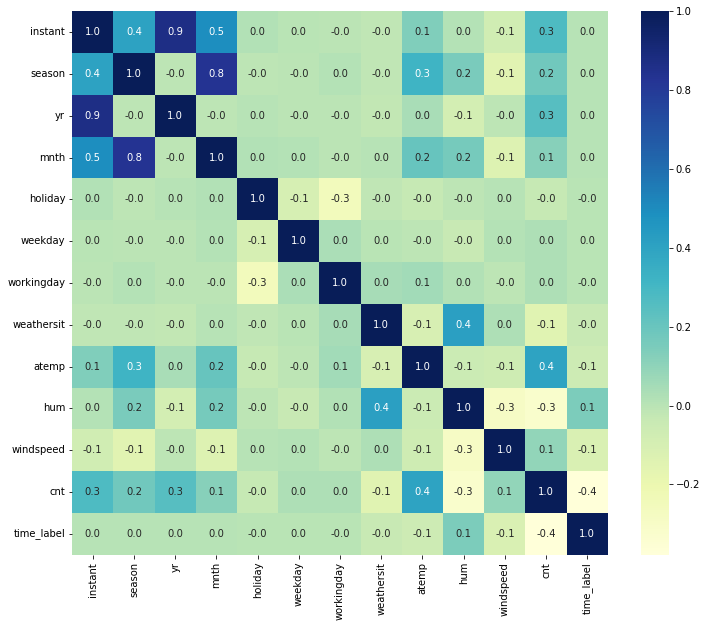

In [40]:
corrs = bike_rentals_clean.corr()
fig, ax = plt.subplots(figsize=(12,10))  
sns.heatmap(corrs, cmap="YlGnBu",annot=True, fmt= ".1f", ax=ax)

In [41]:
cnt_corrs = abs(corrs['cnt']).sort_values(ascending=False)
cnt_corrs

cnt           1.000000
atemp         0.400929
time_label    0.378318
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

We will use the rest of the columns as features for our model and proceed to randomize the dataset and allocate 80% of the dataset to training and 20% to testing.

In [31]:
features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed', 'time_label']
target = 'cnt'
train = bike_rentals.sample(frac=0.8, random_state=1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Training and Testing
### Linear regression model

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(train[features], train[target])
lr_predictions = lr.predict(test[features])
lr_rmse = np.sqrt(mean_squared_error(test[target], lr_predictions))
print("Linear regression error:", lr_rmse)

Linear regression error: 137.30670497479272


### Decision Tree Regressor model

In [33]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(train[features], train[target])
dt_predictions = dt.predict(test[features])
dt_rmse = np.sqrt(mean_squared_error(test[target], dt_predictions))
print("Decision Tree error: ", dt_rmse)

Decision Tree error:  144.709319642985


The model performed worse than the simple Linear regression. Most probably due to overfitting, as we haven't adjusted any parameters that could reduce it. 

### Random Forest Regressor model

In [34]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(train[features], train[target])
rf_predictions = rf.predict(test[features])
rf_rmse = np.sqrt(mean_squared_error(test[target], rf_predictions))
print("Random Forest error: ", rf_rmse)

Random Forest error:  108.58092458464348


Random Forest gave much better result than Linear Regression or Decision Tree. Still, the model errs by 108 bike rentals per instance, which is more than 75% for half of our records. 

We will now tweak it's parameters to see if we can further improve the performance. Using Randomized Search algorithm with 3 fold cross validation (cv=1), search across 100 different combinations (n_iter=100), and all available processing cores (n_jobs=-1), we will experiment with 
- `min_samples_leaf` which is the minimum number of samples required to be at a leaf node, 
- `n_estimators` which is the amount of trees the algorithm creates, 
- `max_depth` which is the maximum amount of levels in each tree, and 
- `min_samples_split`, the minimum number of data points placed in a node before the node is split.

In [24]:
random_grid = {
"min_samples_leaf": [1, 2, 4],
"min_samples_split": [2, 5, 10],
"n_estimators" : [50, 100, 150, 200, 300, 400, 500, 1000],
"max_depth" : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
}

from sklearn.model_selection import RandomizedSearchCV
random_rf = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=1, n_jobs = -1)
random_rf.fit(train[features], train[target])
print(random_rf.best_params_)
random_rf_predictions = random_rf.predict(test[features])
random_rf_rmse = np.sqrt(mean_squared_error(test[target], random_rf_predictions))
print("Random Forest with grid search error: ", random_rf_rmse)

{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 70}
Random Forest with grid search error:  107.45392850848317


We now will try searching for better feature combination.

In [45]:
sorted_features = list(cnt_corrs[1:].index)

for i in range(1,13):
    loop_features = sorted_features[:i]
    loop_rf = RandomForestRegressor(n_estimators=150, min_samples_split=2,min_samples_leaf=4, max_depth=70)
    loop_rf.fit(train[loop_features], train[target])
    loop_predictions = loop_rf.predict(test[loop_features])
    loop_rmse = np.sqrt(mean_squared_error(test[target], loop_predictions))
    print("Root square error with {} features: ".format(loop_features), loop_rmse)


Root square error with ['atemp'] features:  160.4239131010993
Root square error with ['atemp', 'time_label'] features:  131.0893560226787
Root square error with ['atemp', 'time_label', 'hum'] features:  127.99017347818868
Root square error with ['atemp', 'time_label', 'hum', 'instant'] features:  111.45221333109455
Root square error with ['atemp', 'time_label', 'hum', 'instant', 'yr'] features:  111.46580457801164
Root square error with ['atemp', 'time_label', 'hum', 'instant', 'yr', 'season'] features:  111.55997669839566
Root square error with ['atemp', 'time_label', 'hum', 'instant', 'yr', 'season', 'weathersit'] features:  111.5899142793415
Root square error with ['atemp', 'time_label', 'hum', 'instant', 'yr', 'season', 'weathersit', 'mnth'] features:  111.81381744372513
Root square error with ['atemp', 'time_label', 'hum', 'instant', 'yr', 'season', 'weathersit', 'mnth', 'windspeed'] features:  111.48884241573074
Root square error with ['atemp', 'time_label', 'hum', 'instant', 'yr

It seems that using all the features was already the best combination of features. What else can we try?
- calculate additional features, such as an index combining temperature, humidity, and wind speed,
- Predict `casual` and `registered` instead of `cnt`.